In [190]:
from __future__ import absolute_import, unicode_literals, print_function
import numpy as np
from numpy import pi, cos
import pymultinest as pys
import corner
import numpy as np
import pylab as plt
from scipy.linalg import logm
import corner
import scipy.stats as stat
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
plt.style.use('classic')

%matplotlib inline


Text(0,0.5,'Y Position')

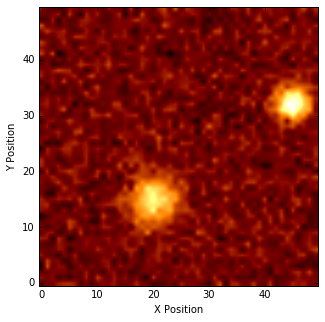

In [191]:
# probability function, taken from the eggbox problem.

def tau(x,y,X,Y,R,A):  #Circularly  Gaussian Shaped function
    term1 = ((x-X)**2 + (y-Y)**2)/(2*R**2)
    return A*np.exp(-term1)

# Position x,y
x = np.arange(0, 50, 1, float)
y = x[:,np.newaxis]


# Sources

#1
X_true = 20
Y_true = 15
R_true = 3
A_true = 4

#2
X1_true = 45
Y1_true = 32
R1_true = 2
A1_true = 6

source1_template = tau(x,y,X_true,Y_true,R_true,A_true)+tau(x,y,X1_true,Y1_true,R1_true,A1_true) 



# ADD noise of 2 units level

noise = np.random.normal(2,.5,source1_template.shape)
Source = source1_template  + noise


plt.figure(figsize=(5,7))
plt.imshow(Source,origin='lower',cmap='afmhot',)
plt.xlabel('X Position')
plt.ylabel('Y Position')

In [192]:
def Model(x,y,Xm,Ym,Rm,Am,X1m,Y1m,R1m,A1m):  #Model that describes each source
    x = np.arange(0, 50, 1, float)
    y = x[:,np.newaxis]
 
    source_template = tau(x,y,Xm,Ym,Rm,Am)+tau(x,y,X1m,Y1m,R1m,A1m)
    return source_template


def logLike(cube): #Likelihood function
    Xm = cube[0]
    Ym = cube[1]
    Rm = 3     #fixed Spatial extent
    Am = 4     #fixed amplitude

    X1m = cube[2]
    Y1m = cube[3]
    R1m = 2    #fixed Spatial extent
    A1m = 6    #fixed amplitude
    data = Source
    mu = Model(x,y,Xm,Ym,Rm,Am,X1m,Y1m,R1m,A1m)
    LogL = -(len(data)/2)*np.log(2*np.pi)-(len(data)/2)*np.log(3**2)-(1/(2*(3**2)))*(np.sum((data-mu)**2))
    
    return LogL 

def mypriors():
    x = 50*np.random.random()
    y = 50*np.random.random()
    #r = 7*np.random.random()

    x1 = 50*np.random.random()
    y1 = 50*np.random.random()
    #r1 = 7*np.random.random()
    #a = 5*np.random.random()+1
    return np.array([x,y,x1,y1])

def plus(x,y):
    if x>y:
        return x+np.log(1+np.exp(y-x))
    
    else:
        return y+np.log(1+np.exp(x-y))

In [193]:
###################Sample N pionts from prior##########################
n = 500  # Number of live points
objects = np.zeros((n,4))
l_objects = np.zeros((n))
for i in range(n):
    objects[i,:] = mypriors()
    l_objects[i] = logLike(cube = objects[i,:])


In [194]:
nest = 9000
keep = np.zeros((nest,4))
logl_sample = []     #Store Log-likelihood of samples
X_sample = []        #Store prior mass
   

logWT = []  #Store  weight =width*likelihood


logZ = -np.exp(300)     # SUM(weights)= Z Evidence
H = 0

X = 0          # Unit prior mass (Xo = 1)


In [195]:
## MAIN NS LOOP##

#Outer interval 
logw = np.log(1.0 - np.exp(-1.0 / n))

for i in range(nest):
    # Draw worst object with L* from n points
    worst = np.argmin(l_objects)
    
    #Save worst opbject
    keep[i,:] = objects[worst,:]
    logl_sample.append(l_objects[worst])
    
    #Save prior mass
    X_sample.append(logw)
    
    #Weight
    logwt = logw + l_objects[worst]
    
    
    #Save weight
    logWT.append(logwt)
    
    #Update Evidence Z
    logZnew = plus(logZ,logwt)  
    
    #Update H information
    H = np.exp(logwt-logZnew)*l_objects[worst] \
    +np.exp(logZ-logZnew)*(H+logZ)-logZnew
    
    #Update logZ
    logZ = logZnew
    #Shrink interval
    logw -= 1.0/n 
   

    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(objects))
        if (copy != worst):
            theta = objects[copy,:]
            break
    Likelihood_thresh = l_objects[copy]
    sigma = [1.5,1.2,1.3,1.1]                 #[4,5,3,2]
    interval = [0,50]
    Accpt = 0
    
    while True:  #Evolve within current worst likelihood L>L* , draw new point under constraint
        
        new_point = theta + np.random.normal(0,sigma)
        
        for j in range(4):
            interval[0]<= new_point[j] <= interval[1]
            Accpt += 1
        
        if Accpt == 4:
            prior = 1
        else: 
            prior = 0
        
        Likelihood_new = logLike(new_point)*prior
        
        #Chisq
            #chisq_new = -2*np.log(np.exp(Likelihood_new))
        #elif prior==0:
            #chisq_new = 0
            
            
        #chisq_thresh = -2*np.log(np.exp(Likelihood_thresh))
        
        alpha =  np.exp(-(np.exp(Likelihood_new)-np.exp(Likelihood_thresh))/2)                  #np.exp(-(chisq_new-chisq_thresh)/2)
        
        if alpha >= 1:
            objects[worst,:] = new_point  #Replace worst point with new point
            l_objects[worst] = Likelihood_new   #Replace the worst likelihood with new one  
            break
        else:
            u = np.random.uniform()
            if u <= alpha :
                objects[worst,:] = new_point 
                l_objects[worst] = Likelihood_new
                break
            else:
                theta = theta
                
    if i >nest*np.exp(H)/np.log(2.):
        break
        

Z = logZ
Z_err = np.sqrt((H)/n)
H = H        #np.exp(H)/np.log(2.)
print('Evidence Z = {0} +-{1} : Information H = {2} '.format(Z,Z_err,H))

Evidence Z = -718.9904220292733 +-0.17635662058994295 : Information H = 15.550828812952545 


In [196]:

#Normalized samples
wt = np.exp((logWT)-max(logWT))
Weights = wt/sum(wt)

#Effective sample size
effective_sample_size = int(np.exp(-np.sum(Weights*np.log(Weights))))
S = 0
sample = np.zeros((effective_sample_size,4))

# Selecting the Effective sample
while True:
    rnd_point = np.random.randint(len(keep))
    proba = Weights[rnd_point]/max(Weights)
    
    if np.random.rand() < proba:
        sample[S,:] = keep[rnd_point,:]
        S += 1
    if S >= effective_sample_size:
        break
print('Effective Sample Size : {}'.format(effective_sample_size))

Effective Sample Size : 791


In [197]:
X,X_err,X1,X1_err = np.mean(sample[:,0]),np.std(sample[:,0]),np.mean(sample[:,2]),np.std(sample[:,2])
Y,Y_err,Y1,Y1_err = np.mean(sample[:,1]),np.std(sample[:,1]),np.mean(sample[:,3]),np.std(sample[:,3])
print('X: {:.3f}-+{:.3f}  X1: {:.3f}-+{:.3f}'.format(X,X_err,X1,X1_err),"|",'X_true : {} X1_true: {}'.format(X_true,X1_true))
print()
print('Y: {:.3f}-+{:.3f}  Y1: {:.3f}-+{:.3f}'.format(Y,Y_err,Y1,Y1_err),"|",'Y_true: {} Y1_true: {}'.format(Y_true,Y1_true))

X: 20.217-+1.984  X1: 44.739-+1.793 | X_true : 20 X1_true: 45

Y: 14.826-+1.661  Y1: 32.097-+1.388 | Y_true: 15 Y1_true: 32


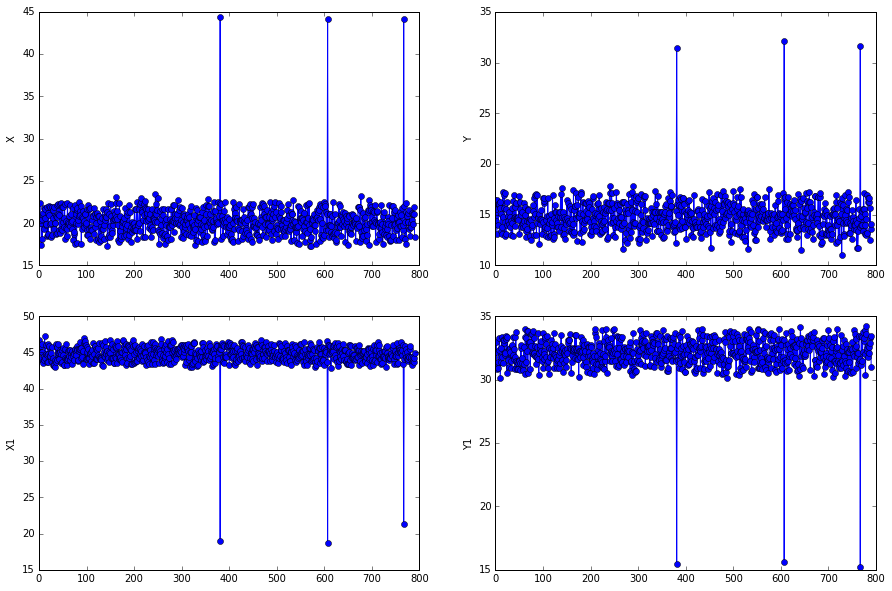

In [198]:
plt.figure(figsize=(15,10))

labels = ['X','Y','X1','Y1']
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(sample[:,i],'-o')
    plt.ylabel(labels[i])


## Trace plots

The two trace plots in each row correspond to a single source with Position X,Y.

#### -  From the trace plots on the left column for the x positons, it can be seen that there is a clear convergence (i.e finding an x position of one source) but at some point there's a jump from one mode to the other and back again??

#### - The same result can be seen on the right column of the Y positions.
    

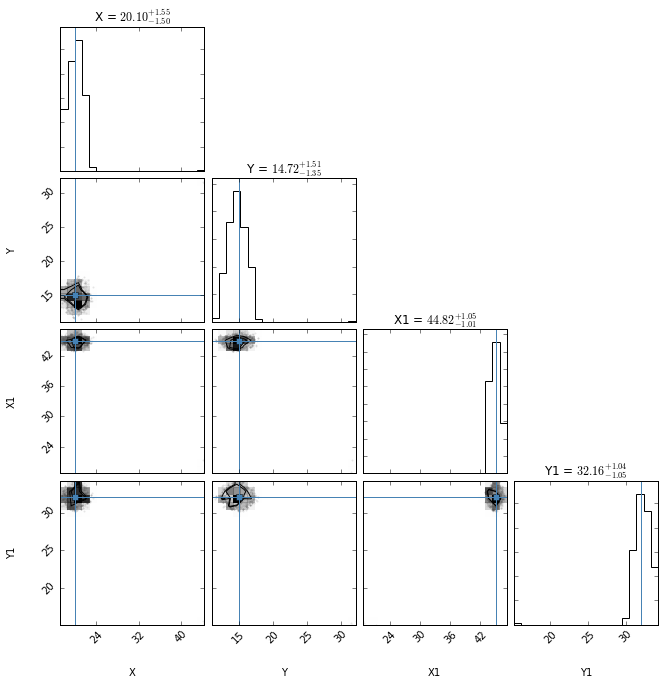

In [199]:
corner.corner(sample,labels=['X','Y','X1','Y1'],show_titles=True,bins=20,levels=[0.5,0.65],truths=[20,15,45,32]);


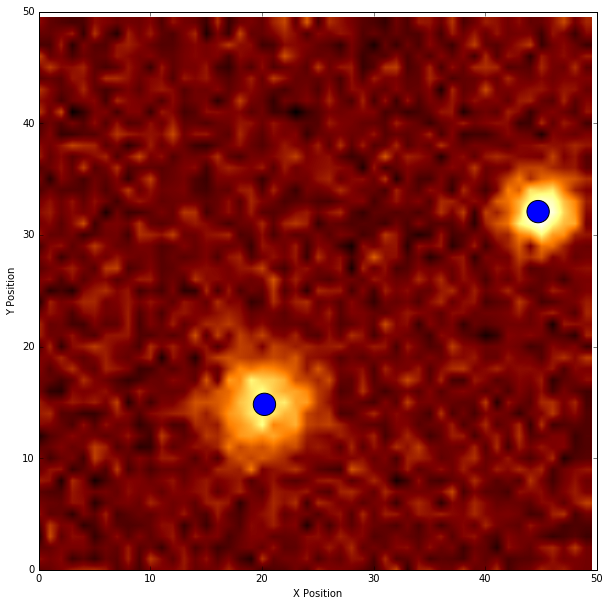

In [200]:
plt.figure(figsize=(10,15))
ax = plt.gca()
ellipses = []
plt.xlim([0,50])
plt.ylim([0,50])
X_pos = [X,X1]
Y_pos = [Y,Y1]
for ra, dec in zip(X_pos,Y_pos):
    ellipse = Ellipse(xy=(ra, dec), width=2, height=2, angle=0)
    ellipses.append(ellipse)

p = PatchCollection(ellipses)
ax.add_collection(p)
plt.imshow(Source,origin='lower',cmap='afmhot',)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

## The circles in blue are the estimated positions X,Y of the sources.